$\newcommand{\R}{\mathbf R}$
$\newcommand{\Id}{{\mathrm{Id}}}$

# Géométrie et espaces de formes - TP 2

## 0. Appariement linéaire (méthode du TP 1)

On reprend la situation de la section 2 du premier TP : on définit une transformation $\phi=\Id+v$ sur $\R^2$ vérifiant des contraintes ponctuelles $\phi(y_i)=z_i$, et telle que $\|v\|_V$ est minimale, où $V$ est un espace de Hilbert de champs de vecteurs de noyau $K_V$. Voici des fonctions reprenant ce qui a été fait dans cette partie : 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Fonctions reprenant les méthodes vues au TP1

def KernelMatrix(x,y,h):
    # calcul de la matrice noyau K(x,y) de taille (m,n)
    # de coefficients K(x_i,y_j) = h(||x_i-y_j||^2) 
    # ou h est une fonction scalaire,
    # les x_i sont m points dans R^d, et les y_j n points dans R^d,
    # donnes sous forme de tableaux x, y de tailles (m,d) et (n,d) 
    return h(np.sum((x[:,None,:]-y[None,:,:])**2,axis=2))

def gauss(sigma) :
    # noyau de Gauss h(r2)=exp(-r2/sigma^2)
    # N.B. l'argument r2 est censé correspondre au carré de la norme euclidienne
    # entre les points (e.g. r2 = ||x-y||^2)
    # Ceci permet d'éviter un calcul de racine carrée inutile et non différentiable en 0.
    def f(r2) :
        return np.exp(-r2/sigma**2)
    return f

def cauchy(sigma) :
    # noyau de Cauchy h(r2)=1/(1+r2/sigma^2)
    def f(r2) :
        return 1/(1+r2/sigma**2)
    return f




def MatchingLinear(y,z,h,l=0):
    # Appariement lineaire de points labellisés dans R^d
    # y et z sont des tableaux de taille (n,d) donnant les coordonnees
    # de n points y_i (points sources) 
    # et leurs correspondants z_i (points cibles)
    # h est la fonction scalaire definissant le noyau,
    # l est le parametre de relaxation,
    # retourne la transformation phi:R^d->R^d realisant l'appariement
    a = np.linalg.solve(KernelMatrix(y,y,h)+l*np.eye(y.shape[0]),z-y)
    def phi(x):
        return x+np.dot(KernelMatrix(x,y,h),a)
    return phi

def MatchingTPS(y,z,l=0):
    # Fonction similaire a MatchingLinear mais la methode utilisee ici 
    # est la methode Thin Plate Splines (cf TP1, questions 13 et 14)
    # remarque : la fonction noyau h(r)=r^2log(r) n'est valable en theorie
    # que pour des donnees en dimension 2.
    def TPSfun(r2):
        # fonction h(r2) = r2 log(sqrt(r2))
        r2[r2==0]=1
        return r2 * np.log(np.sqrt(r2))
    h = TPSfun
    n,d = y.shape
    Kyy =  KernelMatrix(y,y,h) + l*np.eye(n)
    yt = np.concatenate((np.ones((n,1)),y),axis=1)
    M1 = np.concatenate((Kyy,yt),axis=1)
    M2 = np.concatenate((yt.T,np.zeros((d+1,d+1))),axis=1)
    M = np.concatenate((M1,M2))  
    c = z-y
    ct = np.concatenate((c,np.zeros((d+1,c.shape[1]))))
    a = np.linalg.solve(M,ct)
    def phi(x):
        Kxy = KernelMatrix(x,y,h)
        nx = x.shape[0]
        xt = np.concatenate((np.ones((nx,1)),x),axis=1)
        N = np.concatenate((Kxy,xt),axis=1)
        return x+np.dot(N,a)
    return phi





# Fonctions d'affichage

def PlotConfig(lmk, pts=None, clr='k', phi=lambda x:x, withgrid=True, title=None):
    # Fonction pour l'affichage d'une configuration de points, avec ou sans déformation.
    # arguments :
    #    lmk : tableau de taille (n,2), coordonnées des points de référence (y_i ou z_i)
    #    pts : optionnel, tableau (N,2), coordonnées de points additionnels.
    #    clr : optionnel, caractère (ex 'r' ou 'b') spécifiant la couleur utilisée pour afficher les points.
    #    phi : optionnel, fonction Python renvoyée par MatchingLinear ou une méthode similaire,
    #          donnant la transformation phi. Si phi est donné, la transformation phi est appliquée 
    #          sur les points lmk et pts.
    #    withgrid : optionnel, si False, on n'affiche pas la grille de déformation.
    #    title : optionnel, titre de la figure
    if type(pts)==type(None):
        pts = lmk
    plt.axis('equal')
    if withgrid:
        # définition d'une grille carrée adaptée aux points
        mn, mx = lmk.min(axis=0), lmk.max(axis=0)
        c, sz = (mn+mx)/2, 1.2*(mx-mn).max()
        a, b = c-sz/2, c+sz/2
        ng = 200
        X1, X2 = np.meshgrid(np.linspace(a[0],b[0],ng),np.linspace(a[1],b[1],ng))
        x = np.concatenate((X1.reshape(ng*ng,1),X2.reshape(ng*ng,1)),axis=1)
        x = phi(x)
        X1 = x[:,0].reshape(ng,ng)
        X2 = x[:,1].reshape(ng,ng)
        plt.plot(X1,X2,clr,linewidth=.25)
        plt.plot(X1.T,X2.T,clr,linewidth=.25)
    phipts = phi(pts)
    philmk = phi(lmk)
    plt.plot(phipts[:,0],phipts[:,1],'.'+clr,markersize=.1)
    plt.plot(philmk[:,0],philmk[:,1],'o'+clr)
    if title:
        plt.title(title)

def PlotResMatching(phi, lmk1, lmk2, pts1=None, Q=None, withgrid=True, title=None):
    # Fonction pour l'affichage du résultat d'un appariement de points. 
    # arguments :
    #    phi : fonction Python renvoyée par MatchingLinear ou une méthode similaire, donnant la transformation phi
    #    lmk1 : tableau de taille (n,2), coordonnées des points sources (y_i)
    #    lmk2 : tableau de taille (n,2), coordonnées des points cibles (z_i)
    #    pts1 : optionnel, tableau (N,2), coordonnées de points additionnels représentant la forme/image source
    #    Q : optionnel, tableau de taille (n,2,nt) donnant les trajectoires des points de référence (pour la partie 1)
    #    withgrid : optionnel, si False, on n'affiche pas la grille de déformation
    #    title : optionnel, titre de la figure
    PlotConfig(lmk1, withgrid=False, clr='b')
    PlotConfig(lmk2, withgrid=False, clr='r')
    PlotConfig(lmk1, pts=pts1, phi=phi, clr='k', withgrid=withgrid)
    if Q is None:
        Q = np.concatenate((lmk1[:,:,None], lmk2[:,:,None]), axis=2)
    plt.plot(Q[:,0,:].T,Q[:,1,:].T, 'k');
    plt.plot(Q[:,0,1:-1].T,Q[:,1,1:-1].T, 'k+');
    if title:
        plt.title(title)

    
    
# divers

def load(fname='store.pckl'):
    # chargement d'un fichier pickle
    import pickle
    f = open(fname, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

<br>

Voici quelques résultats utilisant ces fonctions. D'abord une configuration aléatoire :

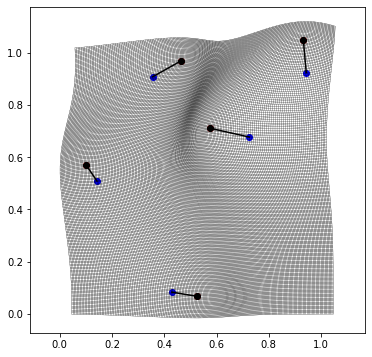

In [4]:
# Exemple d'appariement lineaire avec points aleatoires
lmk1 = np.random.rand(5,2)
lmk2 = lmk1 + .1 * np.random.randn(5,2)
sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))
plt.rcParams['figure.figsize'] = [6, 6]
PlotResMatching(phi,lmk1,lmk2)

<br>

Ensuite des points repérées sur des images de poissons :

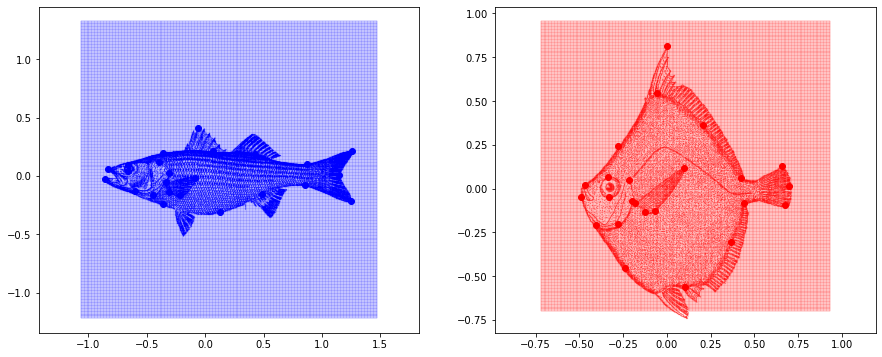

In [5]:
# Chargement et affichage des donnees "poissons"
pts1,pts2,lmk1,lmk2 = load('fish.pckl')
plt.rcParams['figure.figsize'] = [15, 6]
plt.figure()
plt.subplot(1,2,1)
PlotConfig(lmk1, pts1, clr='b')
plt.subplot(1,2,2)
PlotConfig(lmk2,pts2, clr='r')

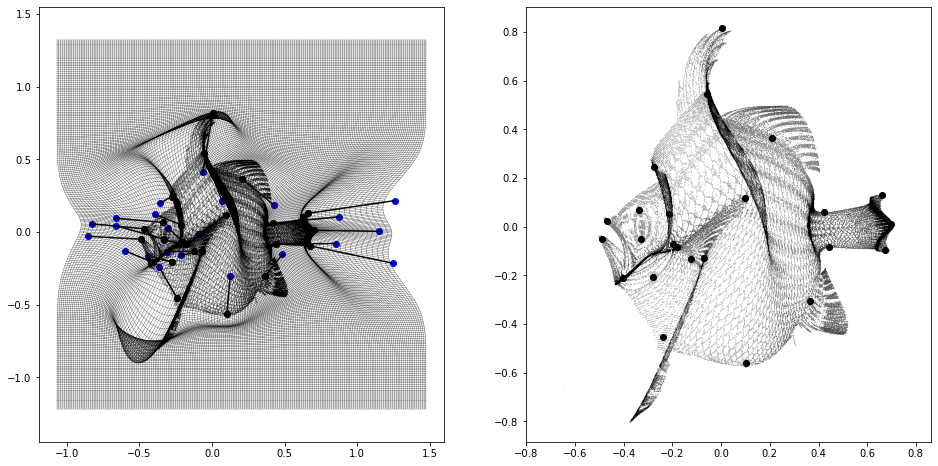

In [6]:
# Appariement lineaire avec les donnees "poissons"
sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1=pts1)
plt.subplot(1,2,2)
PlotConfig(lmk1,pts1,phi=phi, withgrid=False)

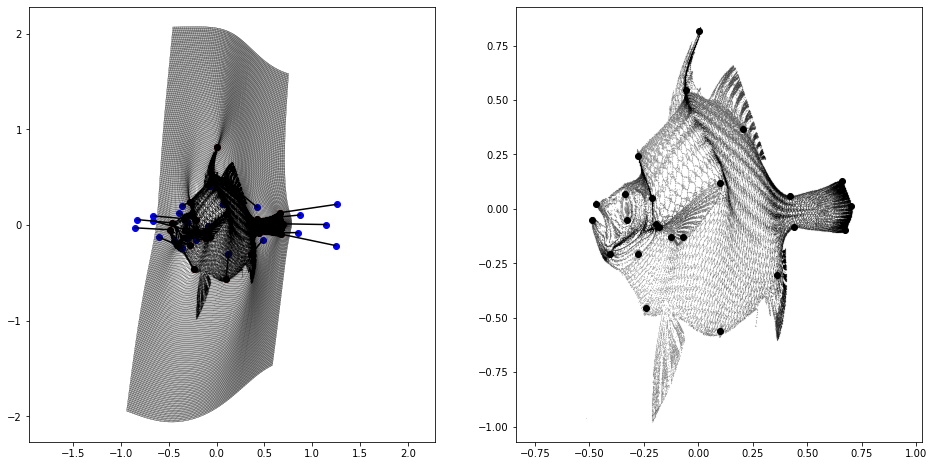

In [7]:
# Appariement par la méthode Thin Plate Splines
sigma = .25
phi = MatchingTPS(lmk1,lmk2)
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1=pts1)
plt.subplot(1,2,2)
PlotConfig(lmk1,pts1,phi=phi, withgrid=False)

$\newcommand{\id}{{\mathrm{id}}\,}$

## 1. De l’appariement linéaire aux difféomorphismes

Nous allons voir comment
la composition de petites déformations permet de résoudre le problème de non-inversibilité de l'approche linéaire.
Pour cela on reprend la situation de la section 2 du premier TP, mais au lieu de réaliser l'appariement des $y_i$ vers les $z_i$ en une seule étape, on introduit des points intermédiaires 
$y_i=q_i^1,q_i^2,\cdots,q_i^{n_t}=z_i$ régulièrement espacés le long du segment $[y_i,z_i]$ et on calcule l'appariement linéaire des $q_i^t$ vers les $q_i^{t+1}$, successivement pour $1\leq t\leq n_t-1$. On compose ensuite simplement les déformations $\phi^t=\id+v^t$ obtenues : $\phi:=\phi^{n_t-1}\circ\cdots\circ\phi^1$. 

Voici une fonction pour calculer les points intermédiaires le long des segments $[y_i,z_i]$:

In [8]:
def LinTraj(y,z,nt=10):
    # renvoie Q tableau de taille (n,d,nt) donnant les coordonnees de points
    # q_i^t de R^d regulierement espaces le long des segments [y_i,z_i]
    # arguments:
    #    y :  tableau (n,d), coordonnées des points y_i
    #    z :  tableau (n,d), coordonnées des points z_i
    #    nt :  nombre de points le long du segment (incluant les extrémités)
    Q = np.dot(y[:,:,None],np.linspace(1,0,nt)[None,:]) + np.dot(z[:,:,None],np.linspace(0,1,nt)[None,:])
    return Q

<br>

__Question 1__ : Tester l'approche proposée sur un exemple où l'appariement linéaire aboutit à une déformation $\phi$ non-inversible (grille de déformation "repliée"). Utiliser la fonction `LinTraj` pour construire les points intermédiaires $q_i^t$ puis écrire une fonction
`MatchingSteps(Q,h)` sur le modèle de `MatchingLinear(y,z,h)`
qui calcule les $\phi(x_j)$ pour des points quelconques $x_j$ donnés en entrée.
Afficher les positions des points et les grilles de déformations obtenues. On testera plusieurs valeurs pour $n_t$ : $n_t=3, 5, 10$ par exemple.

In [92]:
def MatchingSteps(Q,h):
    # appariement de points labellises par composition d'appariement lineaires
    # Q est un tableau de taille (n,d,nt) donnant les coordonnees des points
    # q_i^t de R^d, pour 1 <= i <= n et 1 <= t <= nt
    #
    # ... à compléter

In [ ]:
# test avec les données "poisson"
pts1,pts2,lmk1,lmk2 = load('fish.pckl')

sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))

plt.rcParams['figure.figsize'] = [16, 16]
plt.subplot(2,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1, title="matching linéaire")

Q = LinTraj(lmk1, lmk2, nt=3)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,2)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=3")

Q = LinTraj(lmk1, lmk2, nt=5)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,3)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=5")

Q = LinTraj(lmk1, lmk2, nt=10)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,4)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=10")

$\def\scal#1#2{\left\langle #1\mathbin{,}#2\right\rangle}$
$\newcommand{\i}{^{-1}}$

Les positions des points intermédiaires $q_i^t$, $2\leq t\leq n_t-1$ sont en fait libres et on peut chercher à optimiser ces positions en minimisant l'énergie suivante
$$J(q^2,\ldots,q^{n_t-1}):=\sum_{t=1}^{n_t-1}\scal{q^{t+1}-q^t}{K(q^t)\i(q^{t+1}-q^t)}.$$

Pour éviter le calcul fastidieux du gradient de cette fonctionnelle, nous allons utiliser le module d'autodifférentiation de PyTorch. Voici tout d'abord un mini tutoriel d'introduction. 

In [116]:
# Mini tutoriel d'utilisation de PyTorch et de son module d'autodifferentiation

import torch
from torch.autograd import grad

# definition d'une variable x, vecteur de taille 2 arbitraire, par rapport auquel 
# on pourra calculer des gradients:
x = torch.tensor([1.5,2.4], requires_grad=True)

# On peut aussi partir d'un vecteur numpy et le convertir en variable pytorch :
x_np = np.array([1.5,2.4])
x = torch.tensor(x_np, requires_grad=True)
 
# expression de x dont on doit calculer le gradient :
fx = torch.sum(torch.cos((x**2-2)**2))

# calcul automatique du gradient de f(x) par rapport a x :
# remarque : le [0] a la fin est necessaire car la sortie de grad est un tuple
gfx = grad(fx,x)[0]
print("gradient auto =",gfx)

# on compare avec la formule derivee a la main :
gfx_bis = 2*(x*x-2)*(2*x)*(-torch.sin((x**2-2)**2))
print("gradient mano =",gfx_bis)

# Pour des calculs impliquant des dérivées secondes, il faut spécifier l'option create_graph=True :
fx = torch.sum(torch.cos((x**2-2)**2))
gfx = grad(fx,x,create_graph=True)[0]
g2fx = grad(torch.norm(gfx),x)[0]
print("dérivée seconde =",g2fx)

gradient auto = tensor([ -0.0937, -36.0960], dtype=torch.float64)
gradient mano = tensor([ -0.0937, -36.0960], dtype=torch.float64, grad_fn=<MulBackward0>)
dérivée seconde = tensor([8.9088e-03, 6.0556e+01], dtype=torch.float64)


Pour plus de détails on pourra consulter ce notebook : 
https://nbviewer.org/urls/plmlab.math.cnrs.fr/glaunes/tp_enseignement/raw/master/M2_Percep/Tuto_Autodiff_PyTorch.ipynb

ainsi que toutes les ressources disponibles sur le site de la librairie : https://pytorch.org

<br>

__Question 2__ : Ecrire une fonction `Energy(Q,h)`
qui renvoie la valeur de la fonctionnelle. L'entrée $Q$ est supposée être de type `torch.tensor`, et la fonction $h$ ainsi que la fonction `KernelMatrix` doivent être réécrites avec la syntaxe de PyTorch, de telle manière que la fonction puisse être différentiée.  

In [ ]:
import torch

def gauss_torch(sigma) :
    # version PyTorch de la fonction gauss
    # N.B. on enlève le carré de la formule
    # afin que la fonction passée soit une fonction du carré 
    # de la norme ; ceci pour garder des fonctions différentiables
    def f(r2) :
        return torch.exp(-r2/sigma**2)
    return f

def KernelMatrix_torch(x,y,h):
    # réécriture de KernelMatrix pour utiliser PyTorch à la place de NumPy
    # ... à écrire

def Energy(Q,h):
    # renvoie la valeur de J pour une trajectoire quelconque
    # Q tenseur de taille (n,d,nt) de type torch.tensor
    # h est une fonction scalaire
    # ... à écrire

$ $
$ $

__Question 3__ : Pour $n_t=5$, écrire une descente de gradient à pas fixe sur la fonctionnelle précédente. Tester d'abord pour des configurations de 5 points tirés aléatoirement (faire 2000 itérations, pas de descente $\eta=0.01$), puis pour l'exemple des poissons (prendre $\eta=0.00001$).

$\newenvironment{acc}
{\left\{\begin{array}{l}}
{\end{array}\right.}
\newcommand{\bacc}{\begin{acc}}
\newcommand{\eacc}{\end{acc}}$

__Question 4__ : Expliquer pourquoi le modèle précédent
constitue en fait une première implémentation de l'approche difféomorphique qui définit les déformations $\phi$ par intégration d'une famille de champs de vecteurs
$(v(t,\cdot))_{t\in[0,1]}$ dans $V$:
$$\bacc \phi:=\phi(1,\cdot),\\\frac{\partial\phi}{\partial t}(t,x)=v(t,\phi(t,x)),\eacc$$
et considère le problème d'appariement suivant :
$$(P) \quad \text{Minimiser}\quad J(v)=\int_0^1\|v(t,\cdot)\|_V^2dt\quad\text{sous les contraintes}\quad\phi^v(1,y_i)=z_i,\;\; 1\leq i\leq n.$$

<br>
<br>
<br>

## 2. Approche hamiltonienne et équations géodésiques.

__Question 5__ : Expliquer pourquoi le problème (P) peut s'interpréter comme
un problème de recherche de trajectoire géodésique entre $y$ et $z$ dans l'espace des configurations de $n$ points de $\R^d$
muni d'une certaine métrique locale $\|\cdot\|_q$. 

$\newcommand{\be}{\begin{eqnarray*}}
\newcommand{\ee}{\end{eqnarray*}}
\newcommand{\Norm}[2]{\|#2\|_{#1}}
\newcommand{\qu}{\quad}
\newcommand{\Scal}[3]{\langle#2,#3\rangle_{#1}}
\newcommand{\beq}{\begin{eqnarray}}
\newcommand{\eeq}{\end{eqnarray}}
$

Les équations géodésiques peuvent s'écrire via une formulation hamiltonienne. Pour toute trajectoire $q(t)$, on pose (en omettant la dépendance en $t$ pour simplifier les
écritures): 
- $L(q,\dot q)=\frac12\Norm{q}{\dot q}^2\qu$ (Lagrangien),
- $p=\nabla_{\dot q}L(q,\dot q)\qu$ (gradient de $L$ par rapport à $\dot q$ pour la métrique euclidienne),
- $H(p,q)=\Scal{\R^{2n}}{p}{\dot q}-L(q,\dot q)\qu$ (Hamiltonien)

On montre alors que les trajectoires géodésiques vérifient
$\beq\label{eq:geod}\bacc \dot p=-\nabla_qH(p,q)\\\dot q=\nabla_pH(p,q).\eacc\eeq\qu$ (1) 

<br>

__Question 6__ : Identifier successivement $L(q,\dot q)$, $p$, $H(p,q)$, puis écrire les équations des trajectoires géodésiques. Montrer que $H(p,q)$ est constant pour une trajectoire géodésique. 

<br>

__Question 7__ : Écrire une fonction `Hamilt(p,q,h)` pour calculer $H(p,q)$, puis une fonction `HamiltSys(p,q,h)`  pour le calcul de $(\dot p,\dot q)$ d'après les équations (1), et en utilisant la différentiation automatique. Écrire ensuite une fonction
`Shooting(p0,q0,h)`
qui, à partir d'une configuration $p(0), q(0)$ initiale, résout numériquement l'équation (1) par un schéma d'Euler simple, puis renvoie $p(1)$, $q(1)$ ainsi que $Q$ contenant l'ensemble des trajectoires.
Tester cette fonction pour les configurations précédentes en choisissant des vecteurs moments $p(0)$ aléatoires. Afficher les trajectoires obtenues et la déformation d'une grille régulière.

<br>

__Question 8__ : Enfin 
écrire une fonction `loss(p0,q0,z,h)` renvoyant la somme des carrés des distances des $q_i(1)$ aux $z_i$, et réaliser une descente de gradient simple sur cette fonction afin d'optimiser sur les moments initiaux (faire $1000$ itérations avec pas de descente $0.001$). Afficher les trajectoires $q_i(t)$ et l'appariement difféomorphique obtenu, et comparer avec les 
résultats de la question 3.